In [3]:
# Compara la precipitación y otra variable.

import os


import pandas as pd
import numpy as np
import matplotlib

import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Nos permite obtener nombres y formatos locales, como "Abr" en vez de "Apr".
import locale
# Para Linux y Mac
locale.setlocale(locale.LC_TIME, "es_ES")

'es_ES'

In [4]:
# Rutas de archivos.
path_nc = "../results/CHIRPS_global_days_p05/cuenca_valle_mexico/"
path_shp = "../data/Cuencas/Regiones_Hidrologicas_Administrativas/"
names = ["cuenca_valle_mexico_chirps-v2.0.days_p05.nc", 
    "cuenca_valle_mexico_chirps-v2.0.2021.days_p05.nc",
    "rha250kgw.shp"]
path_d = "../results/onset/"
path_r = "../results/onset/graficas/"

# Variable, nivel de presión y región.
vars = [ "u", "v", "gp", "sst", "olr", "sp", #"vidmf",
    "vivfu", "vivfv" ]
levels = [ "925", "200" ]
zones =  [ (-80, 12.5, -70, 17.5), (-100, 0, -90, 10) ]
anom = [".", "_anom."]
year = np.arange( 1981, 2021 )

# Datos a utilizar.
v = 6
n = 0
d = 20
a = anom[0]

# Cantidad de días a promediar.
d = 20

# Si no existe la carpeta, la crea.
if not os.path.exists(path_r):
    os.mkdir(path_r)

# Información de precipitación
df_pre = pd.read_csv(path_d + "pre_daily_CHIRPS.csv", index_col = "time" )
df_pre.index = pd.to_datetime( df_pre.index )
date_pre = pd.read_csv(path_d + "onset_CHIRPS.csv", index_col = "Año")
# Se convierten las fechas a días julianos.
for i in [0, 1]:
    date_pre.iloc[:, i] = date_pre.iloc[:, i
        ].apply( lambda x: pd.to_datetime(x) )

# Cargamos la variable.

# Variable a utilizar.
if v > 2: lev = ""
else: lev = "_" + levels[n]

# Viento zonal.
fname = ( "onset_" + vars[v] + lev
    + "_mean_" + str(d) + "_dias" + a + "grib" )
ds = xr.open_dataset( path_d + fname, engine = "cfgrib" )

if v < 3:
    ds = ds.drop_vars(["step", "isobaricInhPa", "valid_time"])
elif v < 6:
    ds = ds.drop_vars(["step", "surface", "valid_time"])
else:
    ds = ds.drop_vars(["step", "entireAtmosphere", "valid_time"])

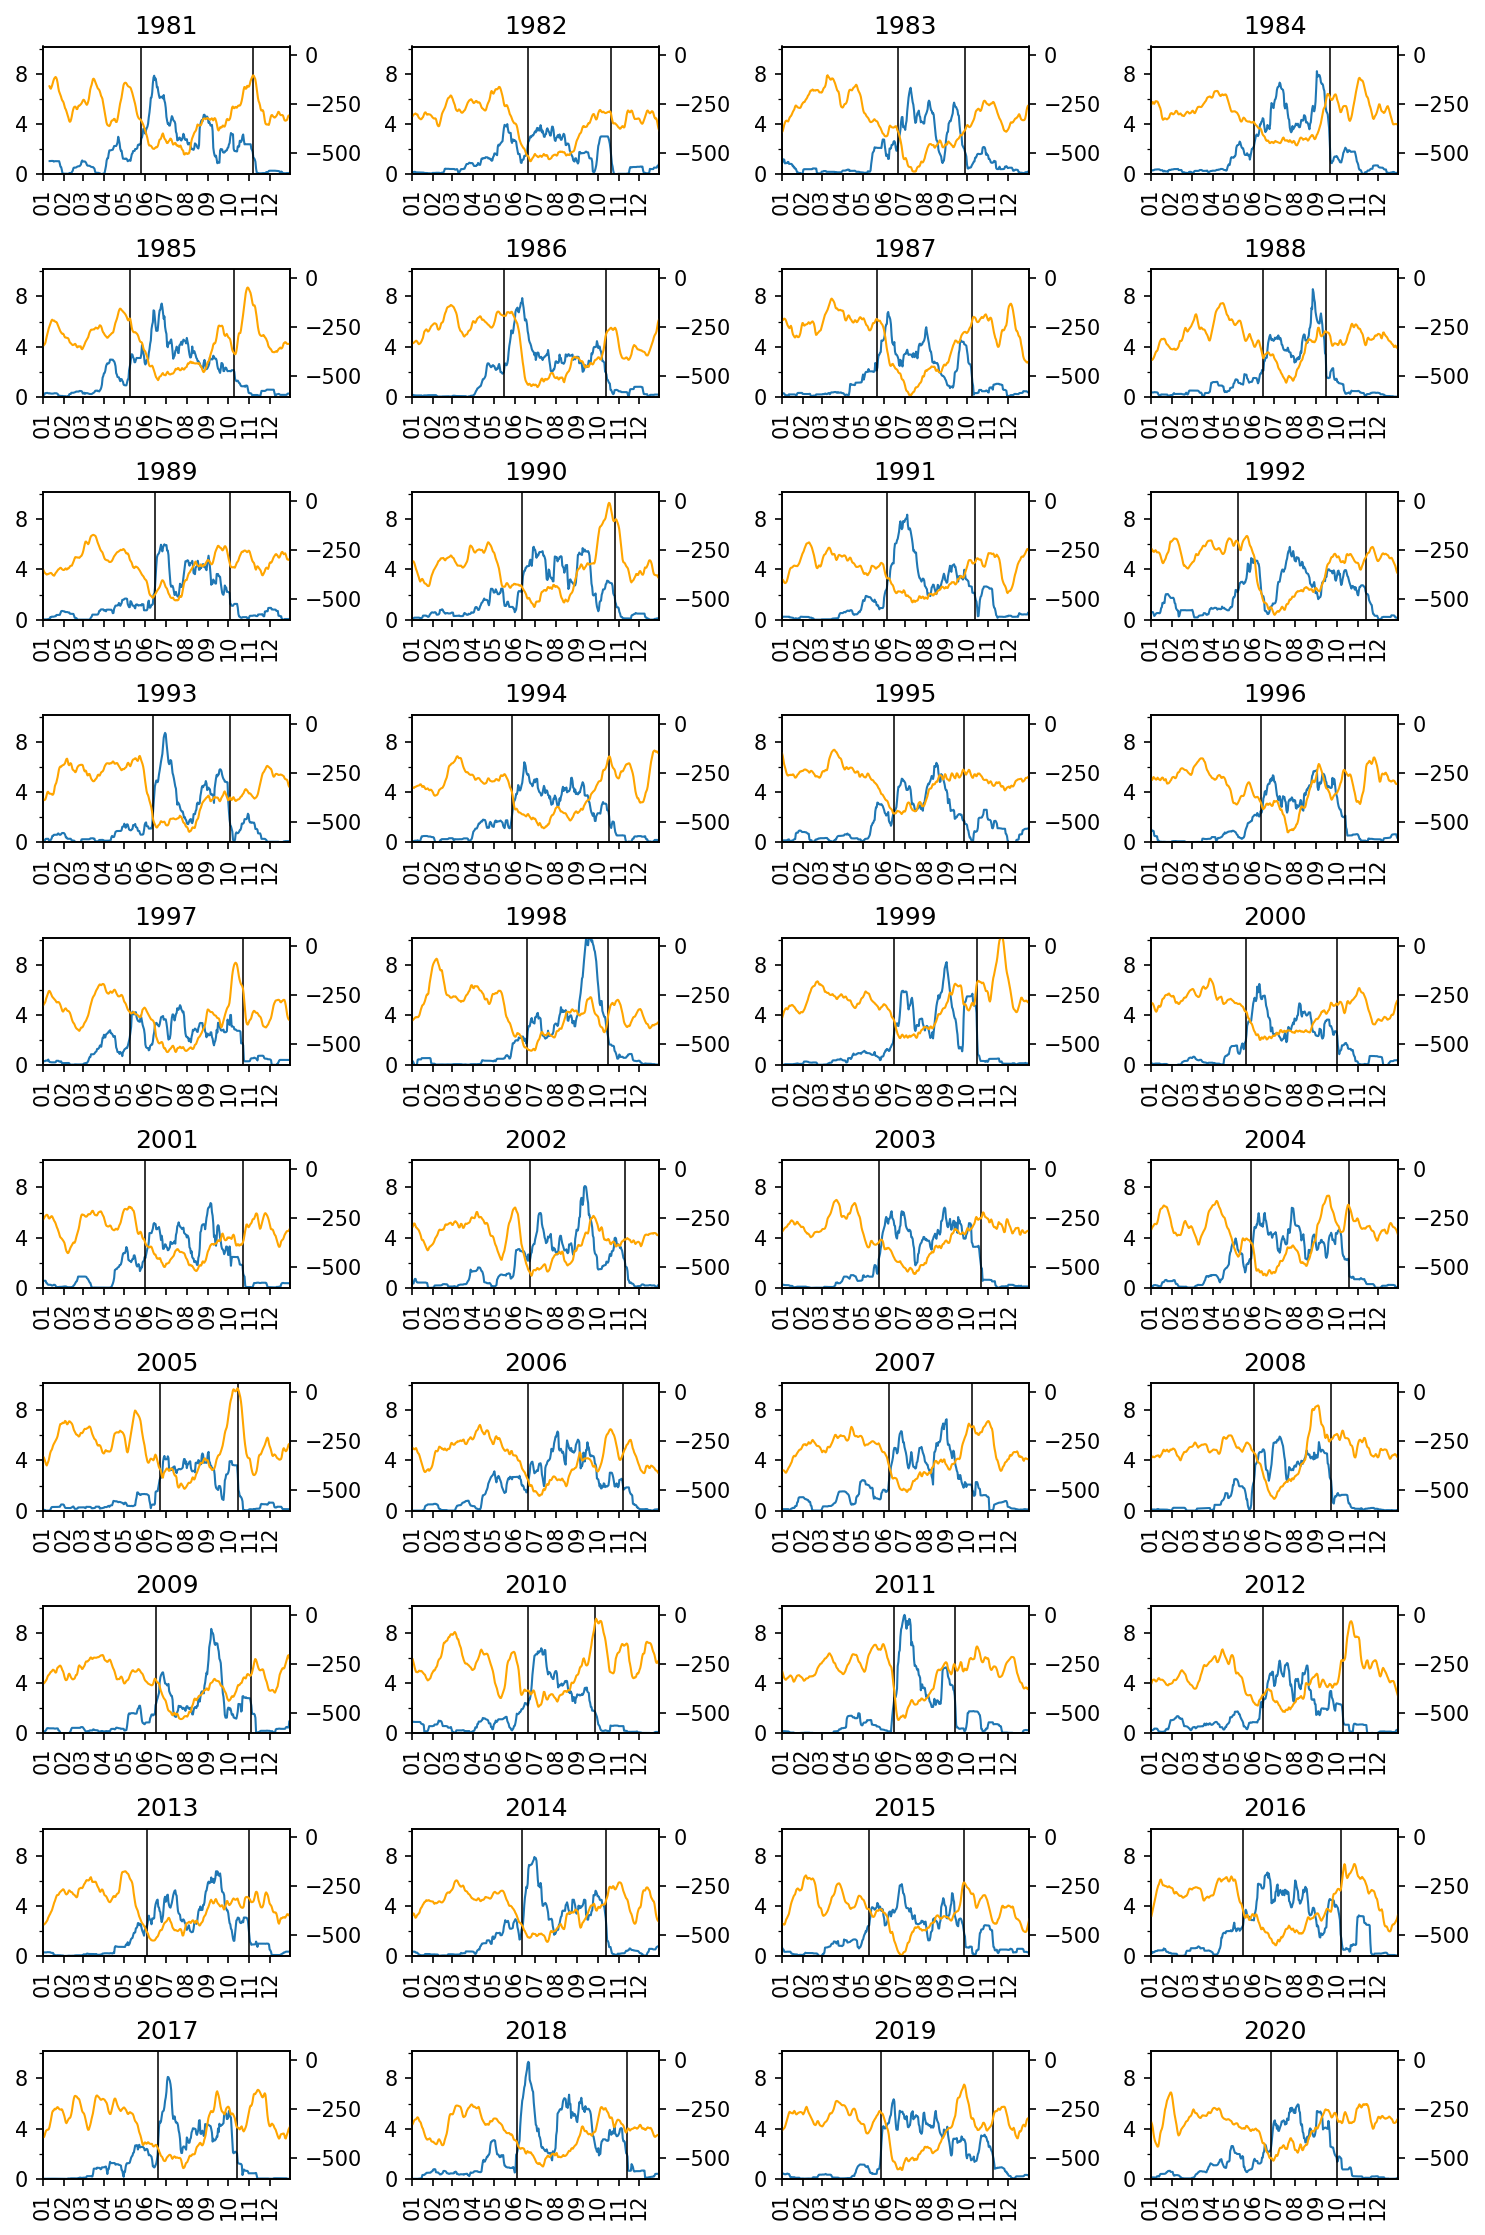

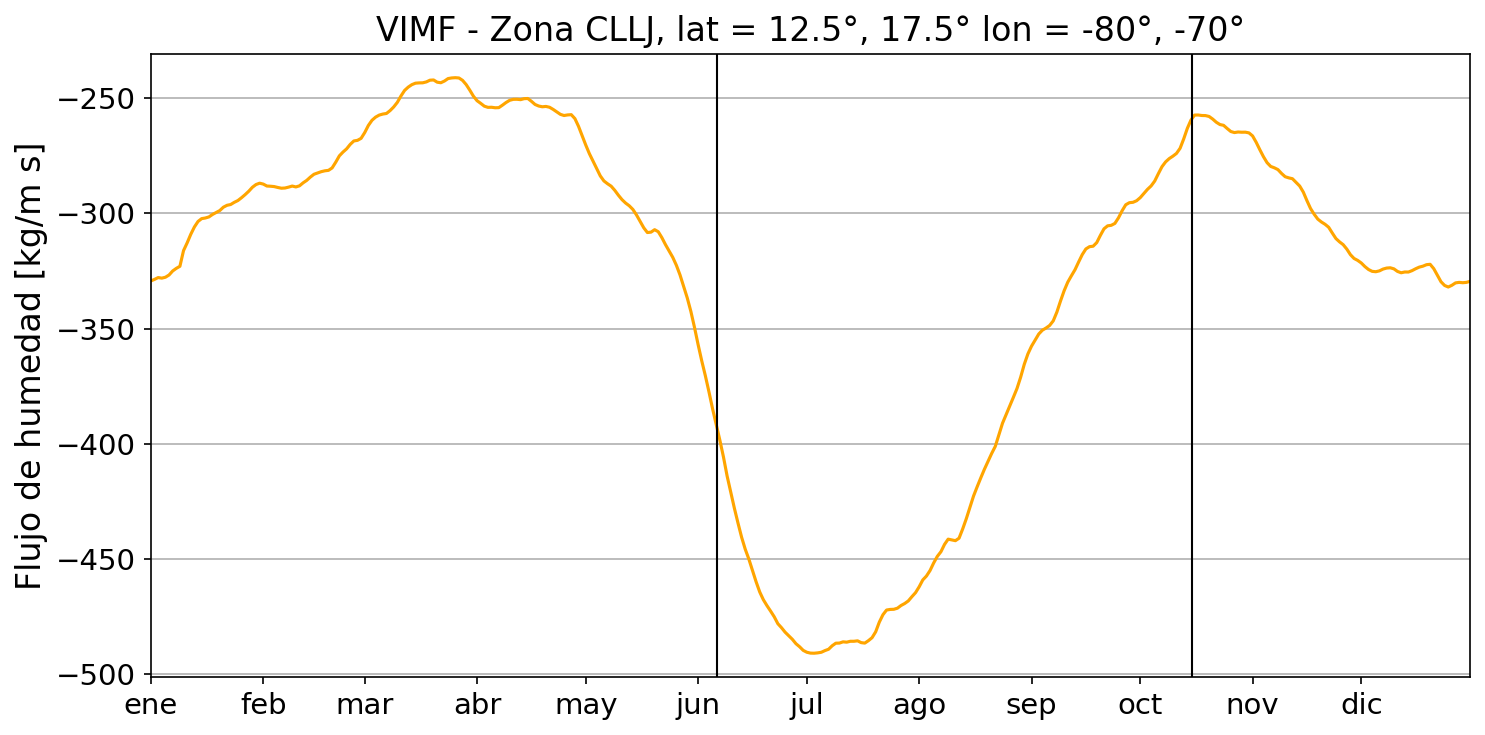

In [5]:
# Primera zona
k = 0

# Seleccionamos la región.
clip = ds.sel( longitude = slice(zones[k][0], zones[k][2]), 
    latitude = slice(zones[k][3], zones[k][1]) ).copy()

# Precipitación diaria promedio en toda la cuenca.
df_var = ( clip.mean(dim = ["latitude", "longitude"]).to_dataframe() )
df_var.columns = ["Cuenca"]

# Graficamos.
fig, axes = plt.subplots(10, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150)

xtick_lab = [ f"{x:02d}" for x in range(1, 13) ]

# Segundo eje.
axes_2 = []

# Iteramos para cada año.
for i in range( len(year) ):
    df_year   = df_pre[ df_pre.index.year == year[i] ]
    df_year_2 = df_var[ df_var.index.year == year[i] ]

    # Fechas.
    onset_pre = date_pre.iloc[date_pre.index == year[i], 0]
    withdrawal_pre = date_pre.iloc[date_pre.index == year[i], 1]

    axes[i].plot(df_year.iloc[:, 0], linewidth = 1)

    axes_2.append( axes[i].twinx() )
    axes_2[i].plot(df_year_2.iloc[:, 0], color = "orange", linewidth = 1)

    min_v = df_pre.min().values[0] - 0.5
    max_v = df_pre.max().values[0] + 0.5

    axes[i].plot( (onset_pre, onset_pre), (min_v, max_v),
        color = "k", linewidth = 0.75 )
    axes[i].plot( (withdrawal_pre, withdrawal_pre), (min_v, max_v), 
        color = "k", linewidth = 0.75 ) 

    axes[i].set_title(year[i])
    axes[i].set_yticks( range(0, 14, 4), minor = False )
    axes[i].set_yticks( range(0, 14, 2), minor = True)
    #axes[0].set_ylabel("Precipitación diaria [mm]")
    #axes[0].set_xlabel("Tiempo")
    axes[i].set_ylim(  df_pre.min().values[0], df_pre.max().values[0])
    axes_2[i].set_ylim(df_var.min().values[0], df_var.max().values[0])
    axes[i].set_xlim( pd.to_datetime( str(year[i]) + "-01-01" ),
        pd.to_datetime( str(year[i]) + "-12-31") )
    # Formato de fecha.
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    axes[i].set_xticks( axes[i].get_xticks(), xtick_lab, rotation = 90 )

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig( path_r + "vivf_yearly_CLLJ.png", bbox_inches = "tight" )

# Comportamiento anual de la variable y fechas medias de índices.

# Cargamos la fecha media de onset. 
date_pre_1 = date_pre.copy()

# Promediamos las fechas
for i in [0, 1]:
    # Convertimos a día juliano.
    date_pre_1.iloc[:, i] = date_pre_1.iloc[:, i].apply(lambda x: x.dayofyear)
    # Ajustamos los años bisiestos.
    date_pre_1.iloc[date_pre_1.index % 4 == 0, i] = date_pre_1.iloc[
        date_pre_1.index % 4 == 0, i ] - 1
    # Reconvertimos a fecha.
    date_pre_1.iloc[:, i] = ( pd.to_datetime("1995-01-01")
        + pd.to_timedelta(date_pre_1.iloc[:, i], "D") )

# Fechas medias.
onset_pre = date_pre_1.iloc[:, 0].mean()
withdrawal_pre = date_pre_1.iloc[:, 1].mean()

pre_xr = clip.copy()

# Seleccionamos los años bisiestos.
leap_xr = pre_xr.sel(time = pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_leap = leap_xr.time.shape[0] / 365
# Ponderación para promedio.
leap_xr *= years_leap
# Promedio por día juliano.
leap_xr = leap_xr.groupby("time.dayofyear").mean()
# Corregimos los días de 1 a 365.
leap_xr["dayofyear"] = np.arange(1, 366)
# Dimensión para concatenar.
leap_xr = leap_xr.expand_dims("concat")

# Seleccionamos los años no bisiestos.
not_leap_xr = pre_xr.sel(time = ~pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_not_leap = not_leap_xr.time.shape[0] / 365  
# Ponderación para promedio.
not_leap_xr *= years_not_leap
# Promedio por día juliano.
not_leap_xr = not_leap_xr.groupby("time.dayofyear").mean()
# Dimensión para concatenar.
not_leap_xr = not_leap_xr.expand_dims("concat")

# Promedio ponderado de años bisiestos y no bisiestos.
pre_xr_mean = xr.concat( (not_leap_xr, leap_xr), "concat"
    ).mean("concat") * 2 / (years_leap + years_not_leap)

# Convertimos a DataFrame.
df_mean_2 = pre_xr_mean.mean( ["longitude", "latitude"]).to_dataframe()
df_mean_2.columns = ["Cuenca"]

# Cambiamos de dayofyear a fecha.
df_mean_2.index = pd.date_range( "1995-01-01", "1995-12-31", freq = "1D" )

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 5)
fig.set_dpi(150)

# Configuración de gráfica.
ax.plot( df_mean_2, color = "orange" )
ax.grid(axis = "y")
ax.set_title("VIMF - Zona CLLJ, lat = "
    + str(zones[k][1]) + "°, " + str(zones[k][3]) + "° lon = "
    + str(zones[k][0]) + "°, " + str(zones[k][2]) + "°", fontsize = 16 )
ax.set_ylabel("Flujo de humedad [kg/m s]", fontsize = 16)
ax.tick_params(axis = "both", which = "major", labelsize = 14)
#ax.set_xlabel("Tiempo")
min_v = df_mean_2.min().values[0] - 0.5
max_v = df_mean_2.max().values[0] + 0.5
ax.set_ylim(min_v - 10, max_v + 10)
ax.set_xlim( pd.to_datetime("1995-01-01"), pd.to_datetime("1995-12-31") )
# Formato de fecha.
ax.xaxis.set_major_locator( mdates.MonthLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter("%b") )

# Onset.
ax.plot( (onset_pre, onset_pre), (min_v - 10, max_v + 10),
    color = "k", linewidth = 1 )
# Withdrawal.
ax.plot( (withdrawal_pre, withdrawal_pre), (min_v - 10, max_v + 10),
    color = "k", linewidth = 1 )

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig( path_r + "vivf_mean_CLLJ.png", bbox_inches = "tight" )

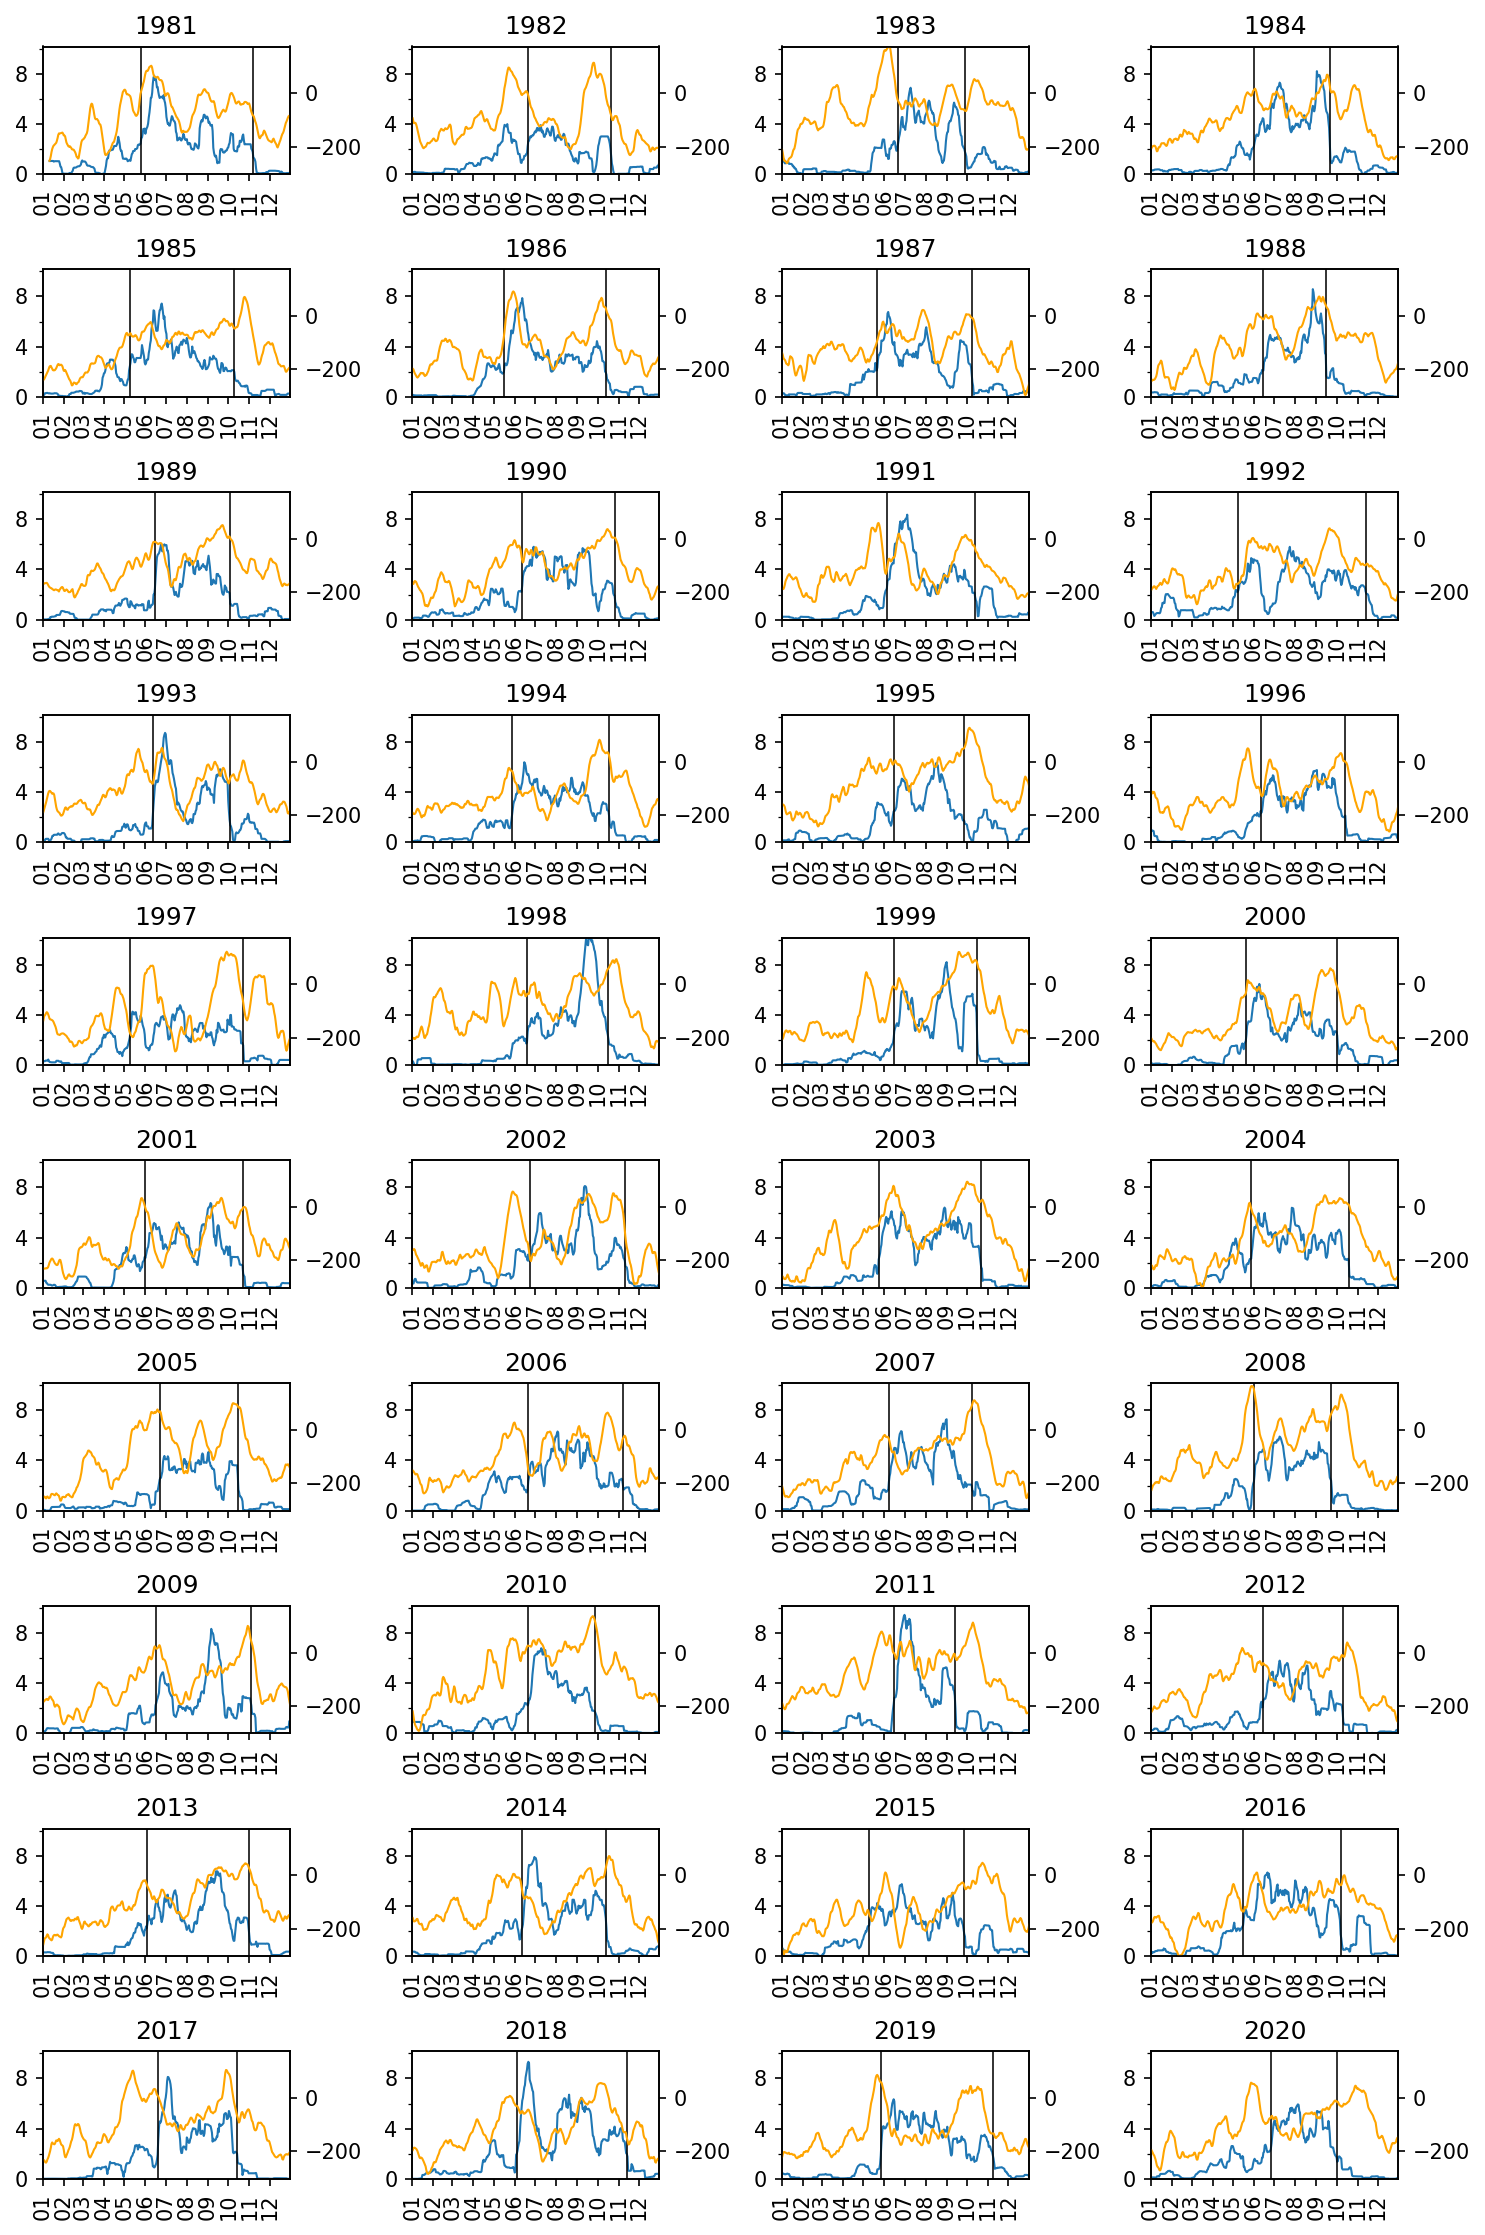

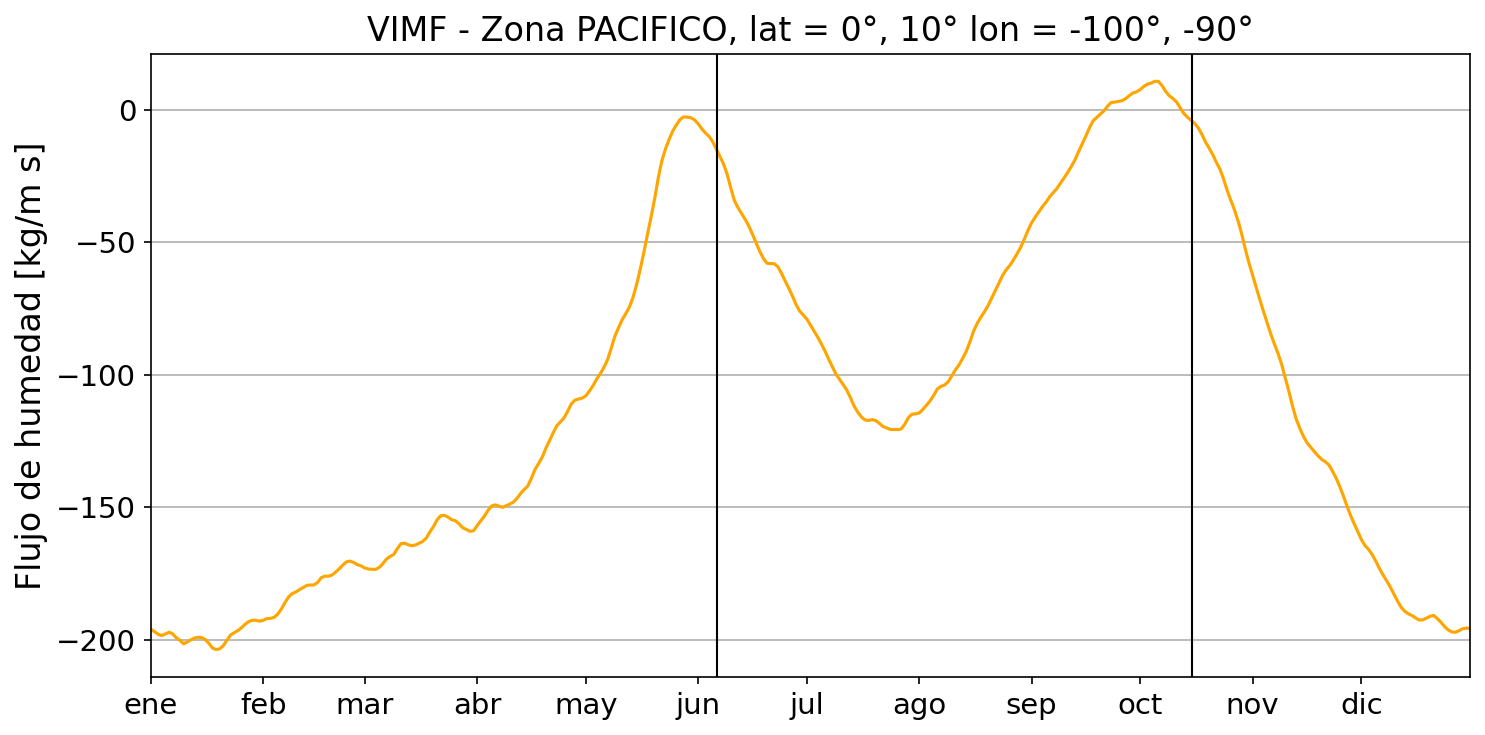

In [6]:
# Segunda zona.
k = 1

# Seleccionamos la región.
clip = ds.sel( longitude = slice(zones[k][0], zones[k][2]), 
    latitude = slice(zones[k][3], zones[k][1]) ).copy()

# Precipitación diaria promedio en toda la cuenca.
df_var = ( clip.mean(dim = ["latitude", "longitude"]).to_dataframe() )
df_var.columns = ["Cuenca"]

# Graficamos.
fig, axes = plt.subplots(10, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150)

xtick_lab = [ f"{x:02d}" for x in range(1, 13) ]

# Segundo eje.
axes_2 = []

# Iteramos para cada año.
for i in range( len(year) ):
    df_year   = df_pre[ df_pre.index.year == year[i] ]
    df_year_2 = df_var[ df_var.index.year == year[i] ]

    # Fechas.
    onset_pre = date_pre.iloc[date_pre.index == year[i], 0]
    withdrawal_pre = date_pre.iloc[date_pre.index == year[i], 1]

    axes[i].plot(df_year.iloc[:, 0], linewidth = 1)

    axes_2.append( axes[i].twinx() )
    axes_2[i].plot(df_year_2.iloc[:, 0], color = "orange", linewidth = 1)

    min_v = df_pre.min().values[0] - 0.5
    max_v = df_pre.max().values[0] + 0.5

    axes[i].plot( (onset_pre, onset_pre), (min_v, max_v),
        color = "k", linewidth = 0.75 )
    axes[i].plot( (withdrawal_pre, withdrawal_pre), (min_v, max_v), 
        color = "k", linewidth = 0.75 ) 

    axes[i].set_title(year[i])
    axes[i].set_yticks( range(0, 14, 4), minor = False )
    axes[i].set_yticks( range(0, 14, 2), minor = True)
    #axes[0].set_ylabel("Precipitación diaria [mm]")
    #axes[0].set_xlabel("Tiempo")
    axes[i].set_ylim(  df_pre.min().values[0], df_pre.max().values[0])
    axes_2[i].set_ylim(df_var.min().values[0], df_var.max().values[0])
    axes[i].set_xlim( pd.to_datetime( str(year[i]) + "-01-01" ),
        pd.to_datetime( str(year[i]) + "-12-31") )
    # Formato de fecha.
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    axes[i].set_xticks( axes[i].get_xticks(), xtick_lab, rotation = 90 )

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig( path_r + "vivf_yearñy_pacific.png", bbox_inches = "tight" )


# Comportamiento anual de la variable y fechas medias de índices.

# Cargamos la fecha media de onset. 
date_pre_1 = date_pre.copy()

# Promediamos las fechas
for i in [0, 1]:
    # Convertimos a día juliano.
    date_pre_1.iloc[:, i] = date_pre_1.iloc[:, i].apply(lambda x: x.dayofyear)
    # Ajustamos los años bisiestos.
    date_pre_1.iloc[date_pre_1.index % 4 == 0, i] = date_pre_1.iloc[
        date_pre_1.index % 4 == 0, i ] - 1
    # Reconvertimos a fecha.
    date_pre_1.iloc[:, i] = ( pd.to_datetime("1995-01-01")
        + pd.to_timedelta(date_pre_1.iloc[:, i], "D") )

# Fechas medias.
onset_pre = date_pre_1.iloc[:, 0].mean()
withdrawal_pre = date_pre_1.iloc[:, 1].mean()

pre_xr = clip.copy()

# Seleccionamos los años bisiestos.
leap_xr = pre_xr.sel(time = pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_leap = leap_xr.time.shape[0] / 365
# Ponderación para promedio.
leap_xr *= years_leap
# Promedio por día juliano.
leap_xr = leap_xr.groupby("time.dayofyear").mean()
# Corregimos los días de 1 a 365.
leap_xr["dayofyear"] = np.arange(1, 366)
# Dimensión para concatenar.
leap_xr = leap_xr.expand_dims("concat")

# Seleccionamos los años no bisiestos.
not_leap_xr = pre_xr.sel(time = ~pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_not_leap = not_leap_xr.time.shape[0] / 365  
# Ponderación para promedio.
not_leap_xr *= years_not_leap
# Promedio por día juliano.
not_leap_xr = not_leap_xr.groupby("time.dayofyear").mean()
# Dimensión para concatenar.
not_leap_xr = not_leap_xr.expand_dims("concat")

# Promedio ponderado de años bisiestos y no bisiestos.
pre_xr_mean = xr.concat( (not_leap_xr, leap_xr), "concat"
    ).mean("concat") * 2 / (years_leap + years_not_leap)

# Convertimos a DataFrame.
df_mean_2 = pre_xr_mean.mean( ["longitude", "latitude"]).to_dataframe()
df_mean_2.columns = ["Cuenca"]

# Cambiamos de dayofyear a fecha.
df_mean_2.index = pd.date_range( "1995-01-01", "1995-12-31", freq = "1D" )

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 5)
fig.set_dpi(150)

# Configuración de gráfica.
ax.plot( df_mean_2, color = "orange" )
ax.grid(axis = "y")
ax.set_title( "VIMF - Zona PACIFICO, lat = " 
    + str(zones[k][1]) + "°, " + str(zones[k][3]) + "° lon = "
    + str(zones[k][0]) + "°, " + str(zones[k][2]) + "°", fontsize = 16 )
ax.set_ylabel("Flujo de humedad [kg/m s]", fontsize = 16)
ax.tick_params(axis = "both", which = "major", labelsize = 14)
#ax.set_xlabel("Tiempo")
min_v = df_mean_2.min().values[0] - 0.5
max_v = df_mean_2.max().values[0] + 0.5
ax.set_ylim(min_v - 10, max_v + 10)
ax.set_xlim( pd.to_datetime("1995-01-01"), pd.to_datetime("1995-12-31") )
# Formato de fecha.
ax.xaxis.set_major_locator( mdates.MonthLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter("%b") )

# Onset.
ax.plot( (onset_pre, onset_pre), (min_v - 10, max_v + 10),
    color = "k", linewidth = 1 )
# Withdrawal.
ax.plot( (withdrawal_pre, withdrawal_pre), (min_v - 10, max_v + 10),
    color = "k", linewidth = 1 )

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig( path_r + "vivf_mean_pacific.png", bbox_inches = "tight" )